In [1]:
import pandas as pd
import time
from datetime import date
from datetime import datetime
from time import mktime
import math

# 1. Finding Similar Costumers

In [2]:
import numpy as np
import sklearn
from sklearn import preprocessing
from tqdm import tqdm
import scipy
import itertools
import collections
import time

In [3]:
df = pd.read_pickle("df.pkl")

In [4]:
def get_customers(df):
    customers = df.drop_duplicates(subset='CustomerID')
    customers = customers.drop(['TransactionID', 'CustomerID'], axis=1)
    return customers

# one hot encoding
def encoder(df):
    # CustomerDOB
    df.CustomerDOB = pd.qcut(df.CustomerDOB.apply(lambda x: x.year), 3, labels = ['age_range_1' , 'age_range_2', 'age_range_3'])
    # CustLocation
    counts = df.CustLocation.value_counts()
    min_frequency = 10
    repl = counts[counts <= min_frequency].index
    df.CustLocation = df.CustLocation.replace(repl, 'others')
    # CustAccountBalance
    df.CustAccountBalance = pd.qcut(df.CustAccountBalance, 3, labels = ['poor' , 'wealthy', 'rich'])
    # TransactionTime
    df.TransactionTime = pd.cut(df.TransactionTime.apply(lambda x: int(x.hour)), bins=[0, 13, 20, 24], labels = ['morning', 'afternoon', 'evening'])
    # TransactionAmount (INR)
    df['TransactionAmount (INR)'] = pd.qcut(df['TransactionAmount (INR)'], 3, labels = ['low', 'medium', 'high'])
    # one hot encoding
    df = pd.get_dummies(df)
    return df

from numpy.core.numeric import outer
def compute_signature(l, hash_functions, D):
    signature = []
    for perm in hash_functions:
        a,b = perm
        min_hash = float('inf')
        for el in l:
            hash = (a*el + b) % D
            if hash < min_hash:
                min_hash = hash
        signature.append(min_hash)
    return signature


def MinHash(df, seed):
    N = 100   #number of hash functions
    D = df.shape[1]   #number of indeces
    minimum = 0    # inclusive
    maximum = D    # exclusive
    signature_matrix = np.zeros([len(df), N], dtype = np.int32)
    p = 2943
    np.random.seed(seed)
    hash_functions = [(np.random.randint(minimum, maximum),np.random.randint(minimum, maximum)) for _ in range(N)]
    df = scipy.sparse.lil_matrix(df)
    for i in tqdm(range(df.shape[0])):
        signature_matrix[i] = compute_signature(df.rows[i], hash_functions, D)
    return signature_matrix

def create_buckets(sig_mat, b, r):
    d, n = sig_mat.shape
    assert(n==b*r)
    buckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=1)
    for i,band in tqdm(enumerate(bands)):
        for j in range(d):
            band_id = tuple(list(band[j,:])+[str(i)])
            buckets[band_id].add(j)
    return buckets

# function that estimate the jaccard similarity
def J_estimate(signature_matrix, user_index1, user_index2):
    return (signature_matrix[user_index1, :] == signature_matrix[user_index2, :]).mean()

# function that find similar customers to a given customer
def find_similars(user_index, buckets):
    similar_users = []
    for value in buckets.values():
        if user_index in value:
              similar_users = similar_users + list(value)
    similar_users = np.unique(np.array(similar_users))
    return similar_users

def compute_threshold(b, r):
    return (1/b)**(1/r)

We choose values of b and r such that the threshold we obtain is very high, specifically around 80%. We see that for b=10 and r=10 the value is about 0.79

In [5]:
compute_threshold(b = 10, r = 10)

0.7943282347242815

In [6]:
query = pd.read_pickle('query_processed.pkl')

In [7]:
# merge the dataset with the query (the queries are the first 50 rows)
query_plus_df = pd.concat([query, df])

In [ ]:
# preprocess dataset
customers = get_customers(query_plus_df)
customers = encoder(customers)
# LSH
t0 = time.time()
signature_matrix = MinHash(customers, seed=1234)
# np.save('/content/drive/MyDrive/ADM/Homework4/signature_matrix.npy', signature_matrix)
# signature_matrix = np.load('/content/drive/MyDrive/ADM/Homework4/signature_matrix.npy')
buckets = create_buckets(signature_matrix, b = 10, r=10)

# find similar customers to the query
query_result = collections.defaultdict(list)
for i in range(len(query)):
    similars = find_similars(i, buckets)
    query_result[i] = similars[similars > 49]  #remove queries themselves from results
t1 = time.time()

100%|████████████████████████████████████████████████████████████████████████| 884265/884265 [01:34<00:00, 9330.63it/s]
3it [00:06,  2.15s/it]

To see if our LSH implementation works well we calculate the mean of the scores for each query element and then compute the mean of the results, this should be around 0.79.

In [ ]:
np.mean(np.array([np.mean(np.array(list(map(lambda x: J_estimate(signature_matrix, i, x), query_result[i])))) for i in range(50)]))

The running time is:

In [ ]:
print((t1-t0))

# 2. Grouping customers together!

## 2.1 Getting your data + feature engineering

In [2]:
data = pd.read_csv("bank_transactions.csv")

In [3]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


We created the seven features. They are the following: <br><br>
    <b>1. no_of_transactions</b> = Number of transactions executed by each customer<br>
    <b>2. no_of_big_transactions</b> = Number of transactions with a balance bigger than 100 dollars<br>
    <b>3. avg_transaction_amount</b> = The average amount of each transfer by each customer<br>
    <b>4. avg_balance</b> = Average balance of each customer<br>
    <b>5. utilisation</b> = Average difference between the balance and the transaction amount for each customer<br>
    <b>6. most_common_gender</b>  = Most common gender of each customer<br>
    <b>7. most_common_location</b>  = Most common location of each customer<br>

In [4]:
data2 = data.groupby(['CustomerID'])['CustomerID'].count().reset_index(name='no_of_transactions')
data3 = data.groupby(['CustomerID'])["TransactionAmount (INR)"].apply(lambda x: (x>100.0).sum()).reset_index(name='no_of_big_transactions')
data_final = pd.merge(data2,data3, on="CustomerID", how='left')

data4= data.groupby(['CustomerID'])["TransactionAmount (INR)"].mean().reset_index(name='avg_transaction_amount')
data_final = pd.merge(data_final,data4, on="CustomerID", how='left')

data4= data.groupby(['CustomerID'])["CustAccountBalance"].mean().reset_index(name='avg_balance')
data_final = pd.merge(data_final,data4, on="CustomerID", how='left')

data4 = data[["CustomerID", "CustAccountBalance", "TransactionAmount (INR)"]]
data4['diff'] = data4["CustAccountBalance"] - data4["TransactionAmount (INR)"]
data4 = data4.groupby(["CustomerID"])["diff"].mean().reset_index(name='utilisation')
data_final = pd.merge(data_final,data4, on="CustomerID", how='left')

data4= data.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode).reset_index(name='most_common_gender')
data_final = pd.merge(data_final,data4, on="CustomerID", how='left')

data4= data.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode).reset_index(name='most_common_location')
data_final = pd.merge(data_final,data4, on="CustomerID", how='left')

C:\Users\borit\AppData\Local\Temp\ipykernel_12516\164496312.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['diff'] = data4["CustAccountBalance"] - data4["TransactionAmount (INR)"]


In [5]:
data_final

,CustomerID,no_of_transactions,no_of_big_transactions,avg_transaction_amount,avg_balance,utilisation,most_common_gender,most_common_location
0,C1010011,2,2,2553.0,76340.635,73787.635,"[F, M]","[NEW DELHI, NOIDA]"
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI
2,C1010014,2,2,727.5,100112.950,99385.450,"[F, M]",MUMBAI
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA
...,...,...,...,...,...,...,...,...
884260,C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI
884261,C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE
884262,C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR
884263,C9099941,1,0,50.0,35295.920,35245.920,M,CHENNAI


We created 20 custom features. They are the following: <br>
<b>1. avg_transaction_time</b> = The average transaction time for each customer<br>
<b>2. age</b> = Average age of the customer in years<br>
<b>3. max_transaction</b> = Biggest transaction of each customer<br>
<b>4. min_transaction</b> = Smallest transaction of each customer<br>
<b>5. avg_perc_transfered</b> = What percentage of the customer's balance has been transferred on average<br>
<b>6. perc_of_big_transaction</b> = Percentage of transactions where a bigger amount than 100 dollars were transferred<br>
<b>7. all_money_transacted</b> = All of the money transacted by each customer <br>
<b>8. avg_afternoon_transaction</b> = The average amount of each transaction in the afternoon by each customer<br>
<b>9. avg_morning_transaction</b> = The average amount of each transaction in the morning by each customer<br>
<b>10. 10th_percentile</b> = 10th percentile of the transactions for each customer<br>
<b>11. 90th_percentile</b> = 90th percentile of the transactions for each customer<br>
<b>12. med_balance </b> = Median balance of each customer<br>
<b>13. med_transaction </b> = Median transaction of each customer<br>
<b>14. no_of_very_big_transaction </b> = Number of transactions with a balance bigger than 1000 dollars<br>
<b>15. max_balance</b> = Maximum amount of the balance of each customer <br>
<b>16. min_balance</b> = Minimum amount of the balance of each customer<br>
<b>17. avg_time_passed</b> = Average time passed between transactions<br>
<b>18. no_of_small_transaction</b> = Number of transactions with a balance smaller than 100 dollars<br>
<b>19. max_utilisation</b> = Biggest utilisation of each customer<br>
<b>20. min_utilisation</b> = Smallest utilisation of each customer<br>

In [6]:
feature= data.groupby(['CustomerID'])["TransactionTime"].mean().reset_index(name='avg_transaction_time')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["TransactionAmount (INR)"].max().reset_index(name='max_transaction')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["TransactionAmount (INR)"].min().reset_index(name='min_transaction')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

In [7]:
#function to add the century to the dates
def getage(value):
    try:
        year = value[-2:]
        if (int(year) > 22):
            year = '19' + str(year)
            return (2022-int(year))
        else:
            year = '20' + str(year)
            return (2022-int(year))

    except Exception as e:
        return 0

feature = data[["CustomerID", "CustomerDOB"]]
feature["age"] = feature['CustomerDOB'].apply(lambda x: getage(x))
feature = feature.groupby(["CustomerID"])["age"].mean().reset_index(name='age')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

C:\Users\borit\AppData\Local\Temp\ipykernel_12516\1375357438.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature["age"] = feature['CustomerDOB'].apply(lambda x: getage(x))


In [8]:
def getpercentage(balance, transaction_amount):
    try:
        return (transaction_amount/balance) * 100

    except Exception as e:
        return 0

feature = data[["CustomerID", "CustAccountBalance", "TransactionAmount (INR)"]]
feature["avg_perc_transfered"] = feature.apply(lambda x: getpercentage(x['CustAccountBalance'], x['TransactionAmount (INR)']), axis=1)
feature = feature.groupby(["CustomerID"])["avg_perc_transfered"].mean().reset_index(name='avg_perc_transfered')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

C:\Users\borit\AppData\Local\Temp\ipykernel_12516\2656666717.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature["avg_perc_transfered"] = feature.apply(lambda x: getpercentage(x['CustAccountBalance'], x['TransactionAmount (INR)']), axis=1)


In [9]:
data_final["perc_of_big_transaction"] = data_final.apply(lambda x: (x['no_of_big_transactions']/x['no_of_transactions'])*100, axis = 1)

feature = data.groupby(['CustomerID'])["TransactionAmount (INR)"].sum().reset_index(name='all_money_transacted')
data_final = pd.merge(data_final, feature, on="CustomerID", how='left')

feature = data.query('TransactionTime < 120000').groupby(['CustomerID'])["TransactionAmount (INR)"].mean().reset_index(name='avg_afternoon_transaction')
data_final = pd.merge(data_final, feature, on="CustomerID", how='left')

feature = data.query('TransactionTime > 120000').groupby(['CustomerID'])["TransactionAmount (INR)"].mean().reset_index(name='avg_morning_transaction')
data_final = pd.merge(data_final, feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["TransactionAmount (INR)"].quantile(0.1).reset_index(name='10th_percentile')
data_final = pd.merge(data_final, feature, on="CustomerID", how='left')

feature = data.groupby(['CustomerID'])["TransactionAmount (INR)"].quantile(0.9).reset_index(name='90th_percentile')
feature = pd.merge(data_final, feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["CustAccountBalance"].median().reset_index(name='med_balance')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["TransactionAmount (INR)"].median().reset_index(name='med_transaction')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature = data.groupby(['CustomerID'])["TransactionAmount (INR)"].apply(lambda x: (x>1000.0).sum()).reset_index(name='no_of_very_big_transactions')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature = data.groupby(['CustomerID'])["TransactionAmount (INR)"].apply(lambda x: (x<100.0).sum()).reset_index(name='no_of_small_transactions')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["CustAccountBalance"].max().reset_index(name='max_balance')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')

feature= data.groupby(['CustomerID'])["CustAccountBalance"].min().reset_index(name='min_balance')
data_final = pd.merge(data_final,feature, on="CustomerID", how='left')


In [10]:
feature = data[["CustomerID", "CustAccountBalance", "TransactionAmount (INR)"]]
feature['diff'] = feature["CustAccountBalance"] - feature["TransactionAmount (INR)"]
feature2 = feature.groupby(["CustomerID"])["diff"].max().reset_index(name='max_utilisation')
data_final = pd.merge(data_final,feature2, on="CustomerID", how='left')
feature2 = feature.groupby(["CustomerID"])["diff"].min().reset_index(name='min_utilisation')
data_final = pd.merge(data_final,feature2, on="CustomerID", how='left')

C:\Users\borit\AppData\Local\Temp\ipykernel_12516\302365062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['diff'] = feature["CustAccountBalance"] - feature["TransactionAmount (INR)"]


In [ ]:
from tqdm import tqdm

#calculates the difference between to dates
def getdiff(custid):
    transactions = data.query('CustomerID == @custid')["TransactionDate"]
    tran_list = transactions.tolist()

    first_tran = tran_list[0]
    first_tran = datetime.strptime(first_tran, "%d/%m/%y")
    tran_list.pop(0)
    sum_diff = 0

    for tran in transactions:
        tran = datetime.strptime(tran, "%d/%m/%y")
        sum_diff += (first_tran - tran).days
        first_tran = tran
    
    if tran_list == []:
        return 0

    return(abs(sum_diff / (len(transactions)-1)))

tqdm.pandas()
#getdiff('C1010014')
data_final["avg_time_passed"] = data_final.progress_apply(lambda x: getdiff(x['CustomerID']), axis=1)

# 2.2 Choose your features (variables)!

We normalised all numerical features with the exception of "no_of_transaction" and age. For the principal component analysis, we deleted all the rows from where any data was missing.

In [60]:
from sklearn.preprocessing import StandardScaler
columns = ["max_utilisation", "avg_transaction_time", "min_utilisation", "min_balance", '10th_percentile', 'avg_morning_transaction', 'avg_afternoon_transaction',  "avg_transaction_amount", "max_balance", "med_transaction", "med_balance", "utilisation", "avg_balance", "max_transaction", "min_transaction"]
data_final_norm = data_final.dropna().loc[:, columns].values
data_final_norm = StandardScaler().fit_transform(data_final_norm)

In [19]:
data_final_norm

array([[-7.95693829e-02, -2.64765193e+00,  2.98970927e-02, ...,
        -5.61085094e-02,  2.31146094e-01,  4.37645046e-02],
       [-1.58713209e-01,  1.31791986e+00, -4.17282275e-02, ...,
        -1.50588442e-01, -1.61814260e-01,  9.61455845e-02],
       [ 1.01351525e-01,  7.22254554e-01, -2.57639757e-02, ...,
         9.83574615e-02, -2.52589296e-01, -2.90164879e-01],
       ...,
       [-8.05589413e-02,  2.41621448e-01,  1.01148029e-03, ...,
        -6.65746745e-02, -2.16757045e-01,  9.17804945e-02],
       [-1.53554246e-01, -2.56628008e+00, -4.22764737e-02, ...,
        -1.46998514e-01, -3.24253798e-01, -3.11990329e-01],
       [-1.56691428e-01,  9.06980535e-01, -2.33576394e-02, ...,
        -1.43670695e-01, -4.26123043e-02, -1.53755817e-01]])

# Principal Component Analysis

5 components -> 92% </br>
3 components -> 77% </br>
2 components -> 67% </br>

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_final_norm)
data_final_norm = pd.DataFrame(data = principalComponents, columns = ['component_1', 'component_2', 'component_3'])

In [21]:
data_final_norm

,component_1,component_2,component_3
0,0.080533,0.603975,0.063059
1,-0.395403,-0.117370,0.083558
2,-0.009924,-0.708665,-0.118948
3,-0.467626,-0.441364,0.101916
4,-0.194437,-0.505227,0.151018
...,...,...,...
51177,-0.420179,-0.564061,0.019011
51178,-0.180120,-0.611524,0.342148
51179,-0.239279,-0.287601,0.065604
51180,-0.545418,-0.707518,0.034672


In [22]:
import numpy as np
np.sum(pca.explained_variance_ratio_)

0.7755864359619521

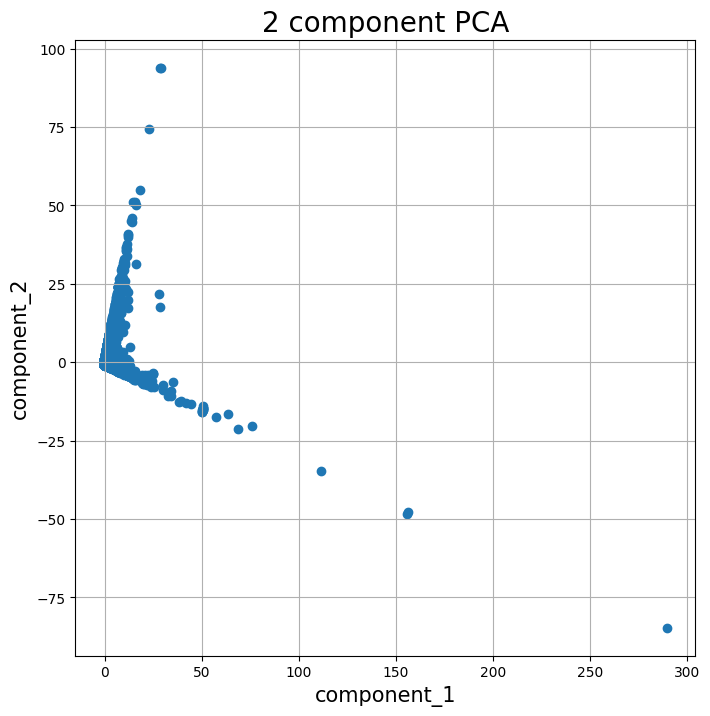

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('component_1', fontsize = 15)
ax.set_ylabel('component_2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(data_final_norm['component_1'], data_final_norm['component_2'])

ax.grid()

# 2.3 Clustering!

In [24]:
def euclidean(x, y): 
    dist = math.pow(x-y, 2)

    return math.sqrt(dist)

In [63]:
def getmean(x):
    sum_x = 0
    for i in x:
        sum_x += i
        
    mean = sum_x/len(x)

    return(mean)

In [34]:
def kmeans_sort(x, centroids):
        
    mean = x["mean"]
    
    min_dist = euclidean(mean, centroids[0])
    min_centroid = centroids[0]
    for c in range(1, len(centroids)):
        dist = euclidean(mean, centroids[c])
        if min_dist > dist:
            min_dist = dist
            min_centroid = centroids[c]
    
    return(min_centroid)

In [65]:
def kmeans(clusters, centroids_no, iterations):
    centroids = []
    for i in range(centroids_no):
        random = np.random.randint(0,len(data_final_norm))
        #data_final_norm.loc[random].mean(axis=0)
        centroids.append(data_final_norm.loc[random].mean(axis=0))
    #data_final_norm["mean"] = data_final_norm.apply(lambda x: getmean(x), axis=1)
    for i in range(iterations):
        data_final_norm["centroid"] = data_final_norm.apply(lambda x: kmeans_sort(x, centroids), axis=1)
        new_centroids = []
        for c in centroids:
            new_centroid = data_final_norm.query('centroid == @c')["mean"].mean()
            new_centroids.append(new_centroid)
        centroids = new_centroids
    
    return(centroids)

In [66]:
kmeans(10,30,5)

[1.8433891296518372,
 -0.19644813828815966,
 -0.2967263637995639,
 0.1458734435784263,
 0.035679405095901846,
 -0.23177938107349125,
 13.961144338888221,
 -0.35036931486626666,
 -0.38279527233290167,
 -0.07819871366557438,
 -0.4119281328512224,
 -0.3117758543300843,
 -0.14014823740367635,
 -0.24994343915776443,
 -0.3598980239429256,
 -0.37050388015446173,
 -0.396836594726436,
 -0.3397360026661568,
 -0.27475407523364354,
 -0.2129821195546626,
 0.34985243880511524,
 -0.18007718025589725,
 -0.3269558616514071,
 -0.11277000853810054,
 -0.26416830099201427,
 -0.28452655222851114,
 -0.16183155389082984,
 -0.03279802239001816,
 4.643110959797558,
 0.7781717687182106]

Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

## Elbow method

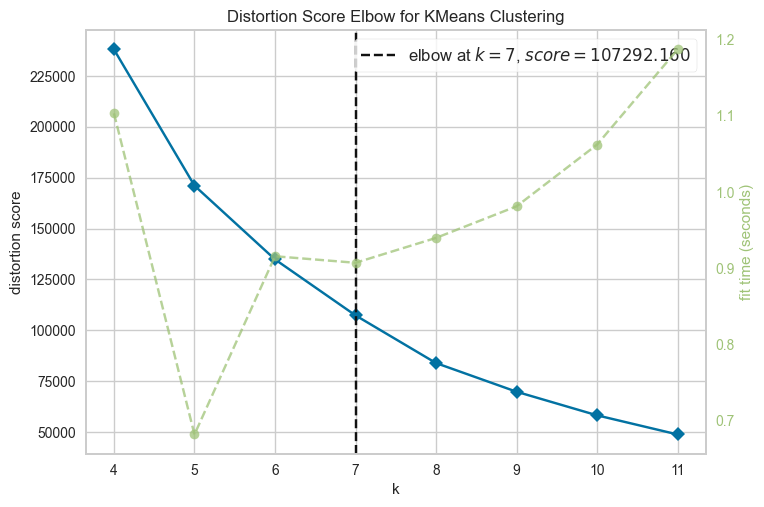

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [74]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

X = kmeans(10,30,5)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
X = np.array(X)

visualizer.fit(data_final_norm)        
visualizer.show()       

## Calinski-Harabasz

C:\Users\borit\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\borit\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


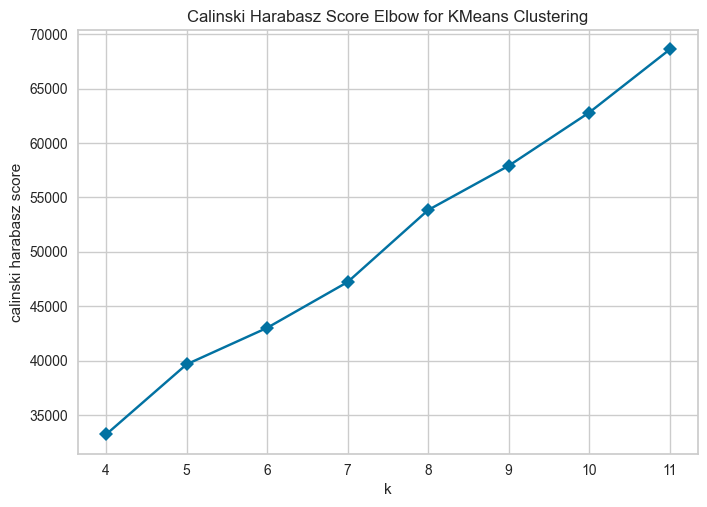

<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [76]:
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(data_final_norm)       
visualizer.show()

# ALGORITHMIC QUESTION

Output “YES” if having G guards is enough to respect the restrictions, and “NO” if it is not enough.

In [ ]:
# 1st line input:
# N = entrances to the uni
# M = students
# G = guards  

N, M, G = list(map(int, input().split()))

# 2nd line input:
# M integers: entry assigned to i-th student
students = list(map(int, input().split()))

guards = 1 #initialize # of guards at 1; with 0 restriction conditions falls
for i in range(1, len(students)):
    if (students[i] != students[i-1]) and (students[i] not in students[:i]):  
        if students[i-1] in students[i+1:]:
            guards += 1
if guards <= G:
    if G == 1:
        print('Yes. ' + str(guards) + ' guard is enough to respect the restriction condition.')
    else:
        print('Yes. ' + str(guards) + ' guards are enough to respect the restriction condition.')
else:
    print('No. '  + str(guards) + ' guards are needed to respect the restriction conditions.')

No. 2 guards are needed to respect the restriction conditions.